<a href="https://colab.research.google.com/github/AkhilVinayakp/HAR_LSTM_CNN/blob/main/lstm_rnn_filt_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

In [ ]:
%cd /content/drive/My\ Drive/datasets 
%pwd

/content/drive/My Drive/datasets


'/content/drive/My Drive/datasets'

In [ ]:
df = pd.read_csv('int_norm.csv')

In [ ]:
df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.054655,0.997718,0.039652
1,33,Jogging,49106062271000,0.405338,0.910910,0.077102
2,33,Jogging,49106112167000,0.410782,0.911708,-0.006846
3,33,Jogging,49106222305000,-0.032685,0.986373,0.161248
4,33,Jogging,49106332290000,-0.083804,0.856341,0.509566
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.968689,-0.168982,0.181898
1098200,19,Sitting,131623371431000,0.970048,-0.156667,0.185640
1098201,19,Sitting,131623411592000,0.972323,-0.147776,0.180972
1098202,19,Sitting,131623491487000,0.969793,-0.157322,0.186416


In [ ]:
sig_x = df['x-axis'].values

In [ ]:
# applying the low pass filter
order = 5


sampling_freq = 50


cutoff_freq = .4


sampling_duration = 2.56


number_of_samples = sampling_freq * sampling_duration
normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq


In [ ]:
def apply_filt(signal):
  numerator_coeffs, denominator_coeffs = butter(order, normalized_cutoff_freq)
  filtered_signal = lfilter(numerator_coeffs, denominator_coeffs, signal)
  return filtered_signal

In [ ]:
sig_x = apply_filt(sig_x)

In [ ]:
sig_y = apply_filt(df['y-axis'].values)
sig_z = apply_filt(df['z-axis'].values)

In [ ]:
sig_x[:10]

array([-5.05776214e-10, -1.22448749e-09,  1.63107275e-08,  1.36937835e-07,
        5.71534589e-07,  1.68654199e-06,  3.99628419e-06,  8.14368134e-06,
        1.48744748e-05,  2.49896358e-05])

In [ ]:
sig_y[:10]

array([9.23289584e-09, 9.92567300e-08, 5.36609398e-07, 1.97808406e-06,
       5.67208716e-06, 1.36169491e-05, 2.86349039e-05, 5.43600753e-05,
       9.52123349e-05, 1.56412899e-04])

In [ ]:
df['x-axis'] = sig_x

In [ ]:
df['y-axis'] = sig_y
df['z-axis'] = sig_z

In [ ]:
def create_windowed_dataset(series, window_size = 128,shift_size=64, batch_size=None,shuffle_buffer=None):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size , shift = shift_size, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.map(lambda window: ( window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6) ))
  dataset = dataset.shuffle(192)
  return dataset

In [ ]:
df.drop('timestamp', axis = 1, inplace=True)
df.activity = df.activity.astype('category').cat.codes
df.activity = df.activity.astype('int64')

In [ ]:
train = df[df['user'] < 31 ]
test = df[df['user'] >= 30]

In [ ]:
train.drop('user', axis = 1, inplace=True)
test.drop('user', axis = 1, inplace=True)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(train.shape)
print(test.shape)


(898361, 4)
(225178, 4)


In [ ]:
train_windowed  = create_windowed_dataset(train)
train_data = list(train_windowed.as_numpy_iterator())
len(train_data)

14035

In [ ]:
train_f = []
train_l = []
for i in train_data:
  train_f.append(i[0])
  train_l.append(i[1])

# converting to numpy array
train_f = np.array(train_f)
train_l = np.array(train_l)
# shape of each
print(f"train features {train_f.shape}")
print(f"train labels {train_l.shape}")

train features (14035, 128, 3)
train labels (14035, 6)


In [ ]:
# creating test set
def create_test_windowed(series, window_size = 128):
  test = tf.data.Dataset.from_tensor_slices(series)
  test = test.window(window_size,shift = 64, drop_remainder = True)
  test = test.flat_map(lambda window: window.batch(window_size))
  test = test.map(lambda window: (window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6)))
  return test

In [ ]:
test_win = create_test_windowed(test)   # test data set for evaluation
test_data = list(test_win.as_numpy_iterator())  # test data set for evaluation
test_f = []
test_l = []
for i in test_data:
  test_f.append(i[0])
  test_l.append(i[1])

test_f = np.array(test_f)
test_l = np.array(test_l)
# shape of each
print(f"test features {test_f.shape}")
print(f"test labels {test_l.shape}")

test features (3517, 128, 3)
test labels (3517, 6)


In [ ]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  # tf.keras.layers.SpatialDropout1D(0.2),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Reshape((128,64,1)),
  tf.keras.layers.Conv2D(128,5,strides=(2,2)),
  tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  # tf.keras.layers.Dropout(.4),
  tf.keras.layers.Conv2D(64,3,strides=(1,1)),  
  # tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_12 (Lambda)           (None, 128, 3)            0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128, 64)           9216      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128, 64)           24832     
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 64, 1)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 30, 128)       3328      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 15, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 13, 64)       

In [ ]:
# designing class back to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
save = ModelCheckpoint('best_model_n3.h5', save_best_only = True)

In [ ]:
# with out bidirection
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model.fit(train_f,train_l,validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192) 

Epoch 1/200
74/74 [==============================] - 10s 72ms/step - loss: 1.4586 - accuracy: 0.4536 - val_loss: 1.0675 - val_accuracy: 0.6989
Epoch 2/200
74/74 [==============================] - 4s 56ms/step - loss: 0.8196 - accuracy: 0.7310 - val_loss: 1.4654 - val_accuracy: 0.5763
Epoch 3/200
74/74 [==============================] - 4s 56ms/step - loss: 0.7239 - accuracy: 0.7611 - val_loss: 0.8773 - val_accuracy: 0.7086
Epoch 4/200
74/74 [==============================] - 4s 56ms/step - loss: 0.6513 - accuracy: 0.7818 - val_loss: 0.8099 - val_accuracy: 0.7373
Epoch 5/200
74/74 [==============================] - 4s 56ms/step - loss: 0.6255 - accuracy: 0.7915 - val_loss: 0.8799 - val_accuracy: 0.6935
Epoch 6/200
74/74 [==============================] - 4s 56ms/step - loss: 0.6043 - accuracy: 0.7945 - val_loss: 0.7773 - val_accuracy: 0.7359
Epoch 7/200
74/74 [==============================] - 4s 56ms/step - loss: 0.5657 - accuracy: 0.8094 - val_loss: 0.7894 - val_accuracy: 0.7228
Epoch

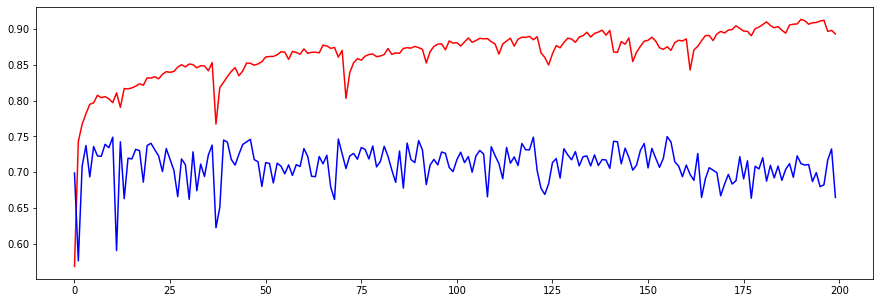

In [ ]:
import matplotlib.pyplot as plt
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()

In [ ]:
b_model = tf.keras.models.load_model('best_model_n3.h5')
b_model.evaluate(test_f, test_l)